In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import os

from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [3]:
seq_len = 200
n_seq = 13
batch_size = 16

feature_columns = ['Ipv', 'Vpv', 'Vdc', 'ia', 'ib', 'ic', 'va', 'vb', 'vc', 'Iabc', 'If', 'Vabc', 'Vf']

# Real data

In [4]:
dataset_folder = '/kaggle/input/gpvs-ts-npy'

x_train_load = np.load(os.path.join(dataset_folder, 'X_train.npy'))
y_train_load = np.load(os.path.join(dataset_folder, 'y_train.npy'))

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train_load.reshape(-1, x_train_load.shape[-1])).reshape(x_train_load.shape).astype(np.float32)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(np.ravel(y_train_load))

n_classes = len(label_encoder.classes_)
print(x_train.shape, y_train.shape)

(48597, 200, 13) (48597,)


In [5]:
uniq_vals, uniq_counts = np.unique(y_train, return_counts=True)
uniq_vals, uniq_counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([3442, 3250, 2692, 3236, 3347, 3451, 1641,  123, 3445, 3443, 3377,
        3434, 3449, 3440, 3442, 3385]))

In [6]:
n_samples_to_gen = np.full(uniq_counts.shape, max(uniq_counts)) - uniq_counts
n_samples_to_gen

array([   9,  201,  759,  215,  104,    0, 1810, 3328,    6,    8,   74,
         17,    2,   11,    9,   66])

In [7]:
y_to_gen = np.hstack([np.repeat(uniq_vals[i], n_samples_to_gen[i]) for i in range(len(uniq_vals))])

In [8]:
y_series = (tf.data.Dataset
               .from_tensor_slices(y_to_gen)
               .shuffle(buffer_size=len(y_to_gen))
               .batch(batch_size, drop_remainder=True))

# Random series generator

In [9]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [10]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# Generate Synthetic Data

In [11]:
synthetic_data = load_model('/kaggle/input/ctimegan-output/time_gan/experiment_00/synthetic_data')

In [12]:
generated_data = []
labels_enc = []
for Y_ in tqdm(y_series):
    Z_ = next(random_series)
    d = synthetic_data([Z_, Y_])
    generated_data.append(d)
    labels_enc.append(Y_)

100%|██████████| 413/413 [00:40<00:00, 10.08it/s]


In [13]:
generated_data = np.array(np.vstack(generated_data))
labels_enc = np.array(np.hstack(labels_enc))

generated_data.shape, labels_enc.shape

((6608, 200, 13), (6608,))

## Rescale

In [14]:
generated_data = (scaler.inverse_transform(generated_data
                  .reshape(-1, generated_data.shape[-1]))
                  .reshape(generated_data.shape))
generated_data.shape

(6608, 200, 13)

# Plot

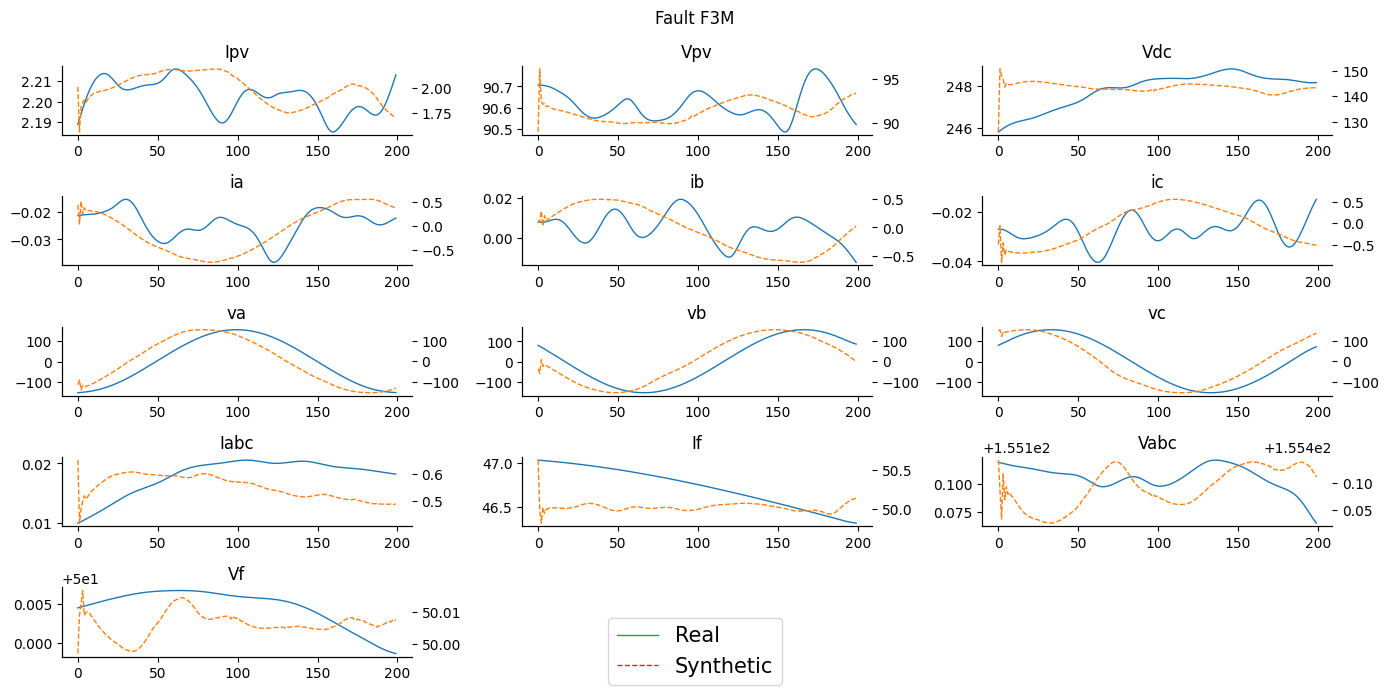

In [15]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(14, 7))
axes = axes.flatten()

idx = np.random.randint(generated_data.shape[0])
synthetic = generated_data[idx]
label = labels_enc[idx]

x_test_label = x_train_load[y_train == label]
real = x_test_label[np.random.randint(x_test_label.shape[0]), :, :]

for j, ticker in enumerate(feature_columns):
    (pd.DataFrame({'Real': real[:, j],
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1,
           legend=None))
    line_real, = axes[j].plot([], [], '-', lw=1, label='Real')
    line_synthetic, = axes[j].plot([], [], '--', lw=1, label='Synthetic')
sns.despine()
fig.legend(handles=[line_real, line_synthetic], labels=['Real', 'Synthetic'], loc='lower center', prop={'size': 15})

fig.delaxes(axes[13])
fig.delaxes(axes[14])
fig.suptitle(f'Fault {label_encoder.inverse_transform([label])[0]}')
fig.tight_layout()

# Save augmented dataset

In [16]:
labels = label_encoder.inverse_transform(labels_enc)
np.unique(labels, return_counts=True)

(array(['F0L', 'F0M', 'F1L', 'F1M', 'F2L', 'F3L', 'F3M', 'F4L', 'F4M',
        'F5L', 'F5M', 'F6L', 'F6M', 'F7L', 'F7M'], dtype='<U3'),
 array([   9,  200,  757,  215,  103, 1807, 3324,    6,    8,   74,   17,
           2,   11,    9,   66]))

In [17]:
np.save('generated_data.npy', generated_data)
np.save('generated_labels.npy', labels)